In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import pathlib
import os
from multiprocessing import Pool

import seaborn as sns
from matplotlib import pyplot as plt
import networkx as nx

import navis 
import navis.interfaces.neuprint as neu
import neuprint as neu_orig
import NeuromodPlasticity as nmp 


plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 


%matplotlib inline

In [2]:
figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/EL_connectomics')
figfolder.mkdir(parents=True, exist_ok=True)

In [3]:
c = nmp.connectomics.npt_client()

In [4]:
# load eb coords
ebcoords = nmp.connectomics.EBCoordinateSystem()
eb = neu.fetch_roi("EB")
eb.vertices = ebcoords.eb_vertices
eb.vertices[:,1] = -eb.vertices[:,1]  # flip y axis to match EB coordinates
eb.vertices[:,2] = -eb.vertices[:,2]

/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/connectomics.py:150: UserWarning: 
The coefficients of the spline returned have been computed as the
minimal norm least-squares solution of a (numerically) rank deficient
system (deficiency=92). If deficiency is large, the results may be
inaccurate. Deficiency may strongly depend on the value of eps.
  self._xsec_rad_spline = sp.interpolate.LSQBivariateSpline(eb_phase, xsec_phase, xsec_rad, knots, knots)


In [5]:
def add_eb_coords(syn_df, ebcoords, type='post'):
    syn_df.loc[:,['x_eb', 'y_eb', 'z_eb']] = ebcoords.change_of_basis(syn_df.loc[:,[f'x_{type}', f'y_{type}', f'z_{type}']].values)
    syn_df.loc[:, ['y_eb', 'z_eb']] = -1*syn_df.loc[:,['y_eb','z_eb']]
    phase, radius = ebcoords.get_circ_coordinates(syn_df.loc[:,['x_eb', 'y_eb', 'z_eb']].values)
    syn_df['phase'], syn_df['radius'] = phase, radius
    syn_df['radius_scaled'] = ebcoords.scale_radius(syn_df['phase'],syn_df['radius'])
    syn_df['xsec_phase'], syn_df['xsec_radius'] = ebcoords.get_xsec_coords(syn_df['phase'],syn_df['radius'], syn_df['z_eb'])
    syn_df['xsec_radius_scaled'] = ebcoords.scale_xsec_rad(syn_df['phase'], 
                                                            syn_df['xsec_phase'], 
                                                            syn_df['xsec_radius'])

    syn_df['xsec_x'] = syn_df['xsec_radius']*np.cos(syn_df['xsec_phase'])
    syn_df['xsec_y'] = syn_df['xsec_radius']*np.sin(syn_df['xsec_phase'])
    syn_df['xsec_x_scaled'] = syn_df['xsec_radius_scaled']*np.cos(syn_df['xsec_phase'])
    syn_df['xsec_y_scaled'] = syn_df['xsec_radius_scaled']*np.sin(syn_df['xsec_phase'])

def change_of_basis(navis_skeleton):
    nodes = navis_skeleton.nodes.copy()
    nodes.loc[:,('x','y','z')] = ebcoords.change_of_basis(nodes.loc[:,('x','y','z')].values)
    nodes.loc[:,'y'] = -nodes.loc[:,'y']  # flip y axis to match EB coordinates
    nodes.loc[:,'z'] = -nodes.loc[:,'z']
    nodes.head()
    navis_skeleton.set_neuron_attributes(nodes,name='nodes')
    return navis_skeleton

In [6]:
# load example ER4d, EPG and an EL that connects them
er4ds, _ = neu.queries.fetch_neurons(neu.NeuronCriteria(type = 'ER4d'))
er2s, _ = neu.queries.fetch_neurons(neu.NeuronCriteria(type = 'ER2.*'))


els, _= neu.queries.fetch_neurons(neu.NeuronCriteria(type = 'EL'))
exr2s, _ = neu.queries.fetch_neurons(neu.NeuronCriteria(type='ExR2'))
exr3s, _ = neu.queries.fetch_neurons(neu.NeuronCriteria(type='ExR3'))
epgs, _= neu.queries.fetch_neurons(neu.NeuronCriteria(type = 'EPG'))

pens, _ = neu.queries.fetch_neurons(neu.NeuronCriteria(type='PEN_a.*'))

example_er4d_bodyId = er4ds['bodyId'].iloc[3]
neuron_df, conn_df = neu.queries.fetch_adjacencies(els['bodyId'], example_er4d_bodyId, rois='EB')
conn_df.sort_values('weight', ascending=False, inplace=True)
example_el_bodyId = conn_df['bodyId_pre'].iloc[0].copy()

neuron_df, conn_df = neu.queries.fetch_adjacencies(epgs['bodyId'], example_el_bodyId, rois='EB')
conn_df.sort_values('weight', ascending=False, inplace=True)
example_epg_bodyID = conn_df['bodyId_pre'].iloc[0].copy()



In [10]:
epgs.shape

(46, 19)

(10, 4)
(9, 4)
(8, 4)
(8, 4)
(10, 4)
(9, 4)
(6, 4)
(9, 4)
(9, 4)
(6, 4)
(8, 4)
(8, 4)
(9, 4)
(9, 4)
(6, 4)
(10, 4)
(8, 4)
(9, 4)


(-0.5, 0.5)

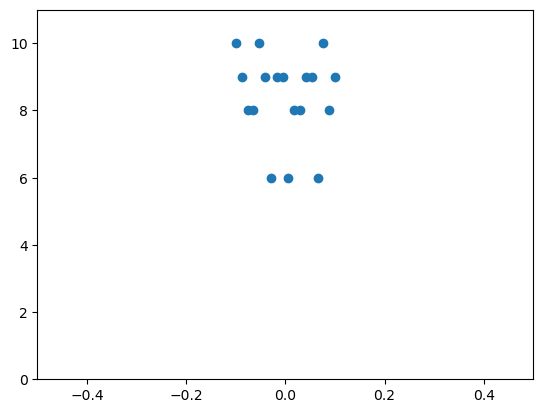

In [ ]:
neuron_df, conn_df = neu.queries.fetch_adjacencies(epgs['bodyId'], els['bodyId'], rois='EB')
n = []
for el in els['bodyId']:
    el_conns = conn_df.loc[(conn_df['bodyId_post']==el) & (conn_df['weight']>10)]
    print(el_conns.shape)
    n.append(el_conns.shape[0])



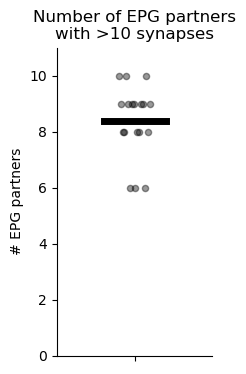

In [28]:
fig, ax = plt.subplots(figsize=(2,4))
ax.scatter(np.linspace(-.1,.1,num=len(n)),n, color='k', s=20, alpha=.4)
ax.plot([-.2,.2],[np.mean(n), np.mean(n)], color='k', linewidth=5)
ax.set_ylim([0,11])
ax.set_xlim([-.5,.5])
ax.set_title('Number of EPG partners\nwith >10 synapses')
ax.set_xticks([0],labels=[''])
ax.set_ylabel('# EPG partners')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(figfolder / 'EL_num_EPG_partners.pdf', bbox_inches='tight')

(array([141.,  28.,  17.,  22.,   9.,   9.,  10.,   6.,   4.,   1.,   3.,
          4.,   7.,   1.,   4.,   1.,   4.,   2.,   2.,   1.,   2.,   1.,
          3.,   2.,   2.,   4.,   3.,   4.,   3.,   0.,   1.,   3.,   3.,
          2.,   5.,   1.,   4.,   2.,   0.,   0.,   3.,   4.,   1.,   1.,
          1.,   1.,   2.,   2.,   0.,   1.]),
 array([  1.  ,   4.16,   7.32,  10.48,  13.64,  16.8 ,  19.96,  23.12,
         26.28,  29.44,  32.6 ,  35.76,  38.92,  42.08,  45.24,  48.4 ,
         51.56,  54.72,  57.88,  61.04,  64.2 ,  67.36,  70.52,  73.68,
         76.84,  80.  ,  83.16,  86.32,  89.48,  92.64,  95.8 ,  98.96,
        102.12, 105.28, 108.44, 111.6 , 114.76, 117.92, 121.08, 124.24,
        127.4 , 130.56, 133.72, 136.88, 140.04, 143.2 , 146.36, 149.52,
        152.68, 155.84, 159.  ]),
 <BarContainer object of 50 artists>)

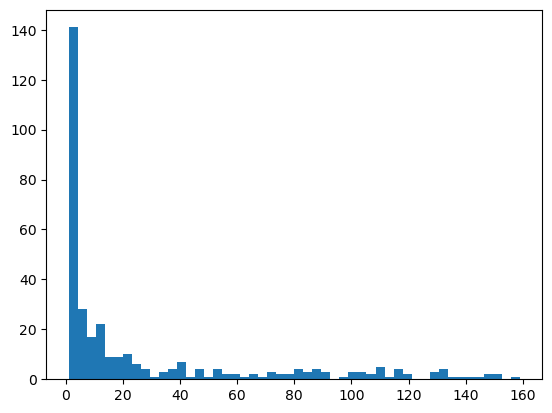

In [11]:
fig, ax = plt.subplots()
ax.hist(conn_df['weight'], bins=50)

In [7]:
er4d_skel = neu.fetch_skeletons(example_er4d_bodyId)
er4d_skel = change_of_basis(er4d_skel)

el_skel = neu.fetch_skeletons(example_el_bodyId)
el_skel = change_of_basis(el_skel)

epg_skel = neu.fetch_skeletons(example_epg_bodyID)
epg_skel = change_of_basis(epg_skel)

pen_skel = neu.fetch_skeletons(pens['bodyId'].iloc[1])
pen_skel = change_of_basis(pen_skel)

er2_skel = neu.fetch_skeletons(er2s['bodyId'].iloc[0])
er2_skel = change_of_basis(er2_skel)

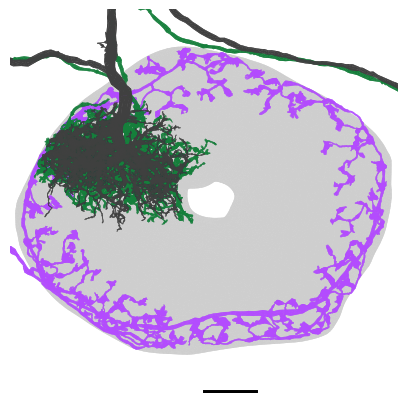

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))
_ = navis.plot2d(
                [eb, er4d_skel, el_skel, epg_skel],
                method="2d",
                connectors=False,
                linewidth=1.2,  # Make neuron a bit thinner to emphasize the synapses
                view=("x", "y"),
                color=(plt.cm.cool(.7), 
                       plt.cm.Greens(.8),
                       plt.cm.Greys(.8),
                       plt.cm.Greys(.3)),
                alpha=1.,
                radius=True,
                ax=ax,
            )
ax.grid(False)
ax.set_xlim([-5100, 5000])
ax.set_ylim([-5000,5000])
ax.plot([0,1000/8*10],[-5000, -5000], linewidth=5, color='black') # 10 micron line
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
for s in ['top', 'left', 'bottom', 'right']:
       ax.spines[s].set_visible(False)

fig.savefig(figfolder / "er4d_epg_el_examples.png", dpi=500,transparent=True)



In [9]:

er4d_epg_synapses = neu_orig.fetch_synapse_connections(example_er4d_bodyId,
                                                       example_epg_bodyID, #epgs['bodyId']
                                                       neu_orig.SynapseCriteria(rois='EB'))

add_eb_coords(er4d_epg_synapses, ebcoords, type='pre')

el_er4d_synapses = neu_orig.fetch_synapse_connections(example_el_bodyId, #els['bodyId'], #
                                                      example_er4d_bodyId,
                                                      neu_orig.SynapseCriteria(rois='EB'))

add_eb_coords(el_er4d_synapses, ebcoords, type='post')

# er4d_neu_skel = neu_orig.fetch_skeleton(example_er4d_bodyId)
# er4d_neu_skel = neu_orig.skeleton.upsample_skeleton(er4d_neu_skel)




  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

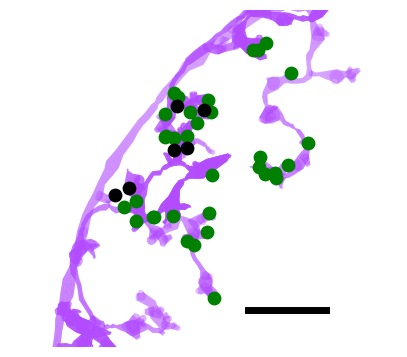

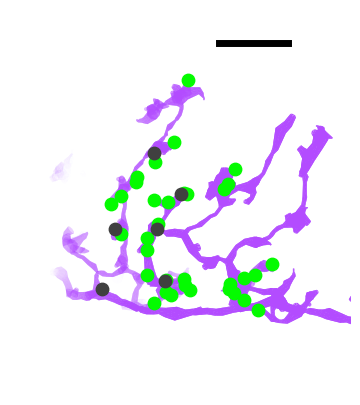

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
_ = navis.plot2d(
                [er4d_skel], #[eb, er4d_skel],
                method="2d",
                connectors=False,
                linewidth=1.,  # Make neuron a bit thinner to emphasize the synapses
                view=("x", "y"),
                # depth_coloring=True,
                # palette='cool',
                shade_by='z',
                smin=-2000, smax=700,
                color=(plt.cm.cool(.7)), 
                     #   plt.cm.Greys(.3)),
                alpha=1,
                radius=True,
                ax=ax,
            )
ax.grid(False)

ax.scatter(er4d_epg_synapses.loc[:,'x_eb'], 
           er4d_epg_synapses.loc[:,'y_eb'],
           s=80, color='black',zorder=101) #plt.cm.Greys(.8))

ax.scatter(el_er4d_synapses.loc[:,'x_eb'],
           el_er4d_synapses.loc[:,'y_eb'],
           s=80, color='green',zorder=100) #color=plt.cm.Greens(.8))

ax.set_xlim([-5100, -2000])
ax.set_ylim([-300,2400])
ax.plot([-3200,-3200+1000/8*5],[0, 0], linewidth=5, color='black') # 5 micron line

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
for s in ['top', 'left', 'bottom', 'right']:
       ax.spines[s].set_visible(False)

fig.savefig(figfolder / "er4d_epg_el_examples_synapses_xy.png", dpi=500, transparent=True)


fig, ax = plt.subplots(figsize=(5, 5))
_ = navis.plot2d(
                [er4d_skel], #[eb, er4d_skel],
                method="2d",
                connectors=False,
                linewidth=1.,  # Make neuron a bit thinner to emphasize the synapses
                view=("x", "z"),
                color=(plt.cm.cool(.7)), 
                    #    plt.cm.Greys(.3)),
                shade_by='y',
                smin=5, smax= 1800,
                alpha=1,
                radius=True,
                ax=ax,
            )
ax.grid(False)

ax.scatter(er4d_epg_synapses.loc[:,'x_eb'], 
           er4d_epg_synapses.loc[:,'z_eb'],
           s=80, color=plt.cm.Greys(.8),zorder=101) #plt.cm.Greys(.8))

ax.scatter(el_er4d_synapses.loc[:,'x_eb'],
           el_er4d_synapses.loc[:,'z_eb'],
           s=80, color=plt.cm.brg(.99),zorder=100) #color=plt.cm.Greens(.8))

ax.set_xlim([-5100, -2000])
ax.set_ylim([-2000,1500])
ax.plot([-3200,-3200+1000/8*5],[1200, 1200], linewidth=5, color='black') # 5 micron line

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
for s in ['top', 'left', 'bottom', 'right']:
       ax.spines[s].set_visible(False)

fig.savefig(figfolder / "er4d_epg_el_examples_synapses_xz.png", dpi=500, transparent=True)

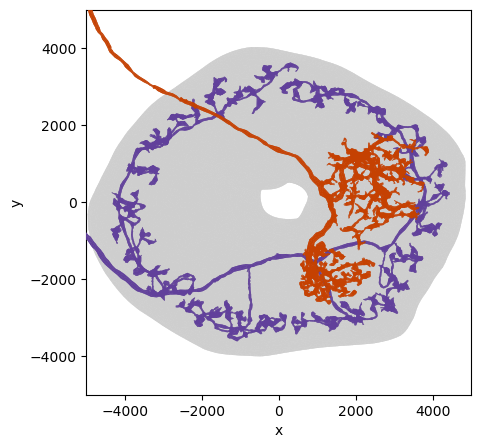

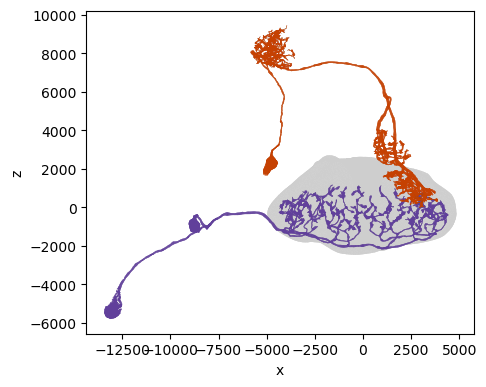

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))
_ = navis.plot2d(
                [eb, er2_skel, pen_skel],
                method="2d",
                connectors=False,
                linewidth=1.2,  # Make neuron a bit thinner to emphasize the synapses
                view=("x", "y"),
                color=(plt.cm.Purples(.8),
                       plt.cm.Oranges(.8), 
                       plt.cm.Greys(.3)),
                alpha=1,
                radius=True,
                ax=ax,
            )
ax.grid(False)



ax.set_xlim([-5000, 5000])
ax.set_ylim([-5000,5000])

fig, ax = plt.subplots(figsize=(5, 5))
_ = navis.plot2d(
                [eb, er2_skel, pen_skel],
                method="2d",
                connectors=False,
                linewidth=1.2,  # Make neuron a bit thinner to emphasize the synapses
                view=("x", "z"),
                color=(plt.cm.Purples(.8),
                       plt.cm.Oranges(.8), 
                       plt.cm.Greys(.3)),
                alpha=1,
                radius=True,
                ax=ax,
            )
ax.grid(False)


In [12]:
pen_er4d_synapses = neu_orig.fetch_synapse_connections(pens['bodyId'],
                                                       er2s['bodyId'],
                                                       neu_orig.SynapseCriteria(rois='EB'))
pen_er4d_synapses

  0%|          | 0/67 [00:00<?, ?it/s]

,bodyId_pre,bodyId_post,roi_pre,roi_post,x_pre,y_pre,z_pre,x_post,y_post,z_post,confidence_pre,confidence_post
0,508793049,1136861363,EB,EB,28295,24250,18330,28319,24252,18335,0.992,0.457052
1,508793049,1260422110,EB,EB,27466,24823,19045,27466,24833,19063,0.983,0.976500
2,508793049,1260422110,EB,EB,27593,24812,19025,27582,24828,19022,0.650,0.808000
3,509410587,5813047647,EB,EB,29174,25004,19648,29153,25004,19627,0.950,0.623389
4,509410587,1199712272,EB,EB,29062,24895,21159,29062,24905,21147,0.956,0.942577
...,...,...,...,...,...,...,...,...,...,...,...,...
62,5813056953,1199712272,EB,EB,28931,25046,21237,28938,25033,21221,0.992,0.991230
63,5813056953,1199712272,EB,EB,28963,24994,21266,28987,24996,21272,0.935,0.994042
64,5813080979,5813047647,EB,EB,22686,24506,18709,22704,24512,18714,0.950,0.972517
65,5813080979,1199699496,EB,EB,22555,24790,19111,22562,24799,19124,0.988,0.999555


In [13]:
import pickle

syndist_folder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/EL_connectomics/syn_distances')



In [14]:
er_types = ('ER4d', 'ER2_a', 'ER2_b', 'ER2_c', 'ER2_d')
df = pd.DataFrame({'er': [], 'source': [], 'distance': []})
for type in er_types[:]:
    file = syndist_folder / f"{type}_syn_distances.pkl"
    with open(file, 'rb') as f:
        distances = pickle.load(f)

    el_dist, exr2_dist = [], []
    for nrn in distances:
        el_dist.append(nrn['cable_distance']['el_post'])
        exr2_dist.append(nrn['cable_distance']['exr2_post'])
    el_dist = np.concatenate(el_dist)
    # el_dist[np.isnan(el_dist)] = np.nanmax(el_dist + 10000/8)

    exr2_dist = np.concatenate(exr2_dist)
    # exr2_dist[np.isnan(exr2_dist)] = np.nanmax(exr2_dist+10000/8)
    names = ['el' for i in range(el_dist.shape[0])] + ['exr2' for i in range(exr2_dist.shape[0])]
    er = [type for i in range(len(names))]
    _df = pd.DataFrame({ 'er': er,
                    'source': names,
                    'distances': np.concatenate((el_dist,exr2_dist))/1000*8})
    df = pd.concat((df,_df), ignore_index=True)



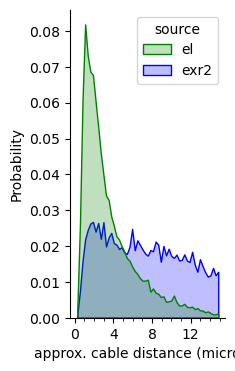

In [15]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

fig, ax = plt.subplots(figsize=[2,4])
sns.histplot(data=df, x='distances', hue='source',  fill=True,common_norm=False, ax=ax, cumulative=False,
            hue_order=('el', 'exr2'), palette=('green', 'blue'),element='poly', stat='probability') #, cut=0,common_grid=True)
# ax.set_xlim([0,10])
ax.set_xlabel('approx. cable distance (microns)')
ax.set_xticks([0,4,8,12])
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.hist(el_dist*8/1000, color='green')
# ax.hist(exr2_dist*8/1000, color='blue')
fig.savefig(figfolder / 'ER4d_dist_to_EPG_syn.pdf')

In [16]:
er_types = ('ER4d', 'ER4m', 
                'ER2_a', 'ER2_b', 'ER2_c', 'ER2_d',
                'ER3w_b', 'ER3a_c', 'ER3p_a', 'ER3w_a', 'ER3a_b', 'ER3p_b', 'ER3d_c', 'ER3d_a',
                'ER3d_d', 'ER3d_b', 'ER3a_a', 'ER3a_d', 'ER3m', 
                'ER1_b', 'ER1_a')
df = pd.DataFrame({'er': [], 'source': [], 'distances': []})

for type in er_types[:]:
    file = syndist_folder / f"{type}_syn_distances.pkl"
    with open(file, 'rb') as f:
        distances = pickle.load(f)

    el_dist, exr2_dist = [], []
    for nrn in distances:
        el_dist.append(nrn['cable_distance']['el_post'])
        exr2_dist.append(nrn['cable_distance']['exr2_post'])
    el_dist = np.concatenate(el_dist)
    # el_dist[np.isnan(el_dist)] = np.nanmax(el_dist + 10000/8)

    exr2_dist = np.concatenate(exr2_dist)
    # exr2_dist[np.isnan(exr2_dist)] = np.nanmax(exr2_dist+10000/8)
    names = ['el' for i in range(el_dist.shape[0])] + ['exr2' for i in range(exr2_dist.shape[0])]
    er = [type for i in range(len(names))]
    _df = pd.DataFrame({ 'er': er,
                    'source': names,
                    'distances': np.concatenate((el_dist,exr2_dist))/1000*8})
    df = pd.concat((df,_df), ignore_index=True)

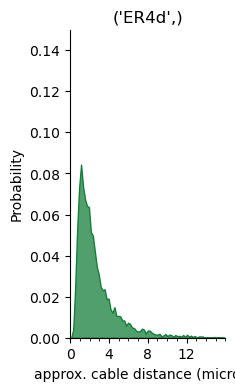

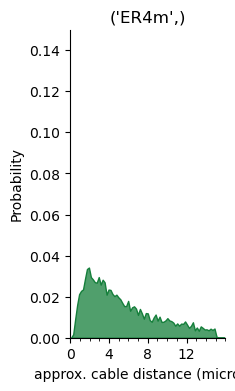

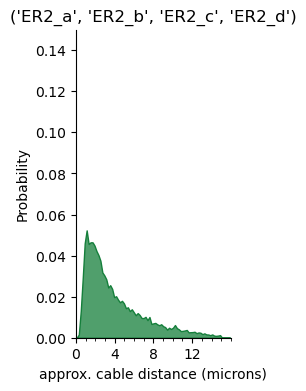

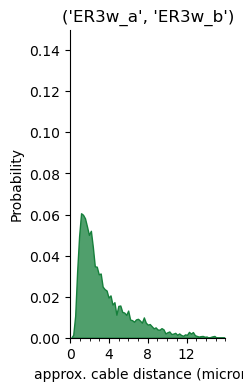

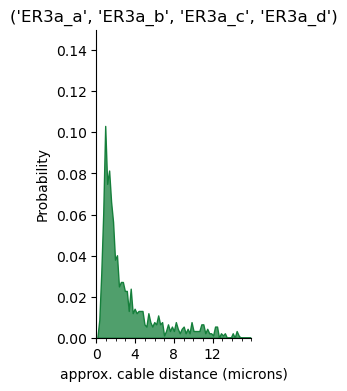

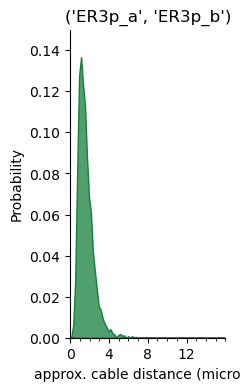

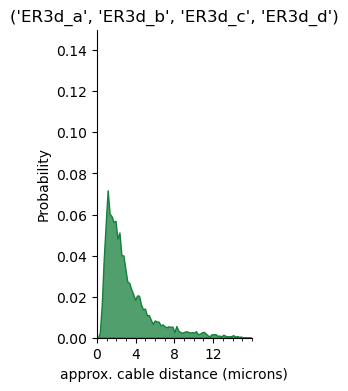

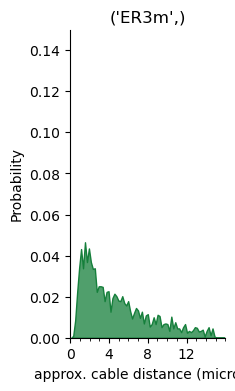

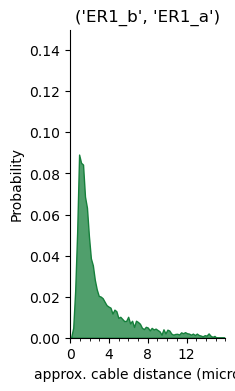

In [17]:
groups = (('ER4d',), ('ER4m',),
          ('ER2_a', 'ER2_b', 'ER2_c', 'ER2_d'),
          ('ER3w_a', 'ER3w_b'), ('ER3a_a', 'ER3a_b', 'ER3a_c', 'ER3a_d'),
          ('ER3p_a', 'ER3p_b'),
          ('ER3d_a', 'ER3d_b', 'ER3d_c', 'ER3d_d'),
          ('ER3m',),
          ('ER1_b', 'ER1_a'))

plot_df = df.loc[df['source']=='el']
bins = np.linspace(0,16,80)
for i, type in enumerate(groups):

    fig, ax = plt.subplots(figsize=[2,4])
    sns.histplot(data=plot_df.loc[plot_df['er'].isin(type)],
                 x='distances', bins=bins, ax=ax, fill=True,
                 stat='probability', element='poly', common_norm=False,
                 cumulative=False, color=plt.cm.Greens(.8))
    ax.set_xlabel('approx. cable distance (microns)')
    ax.set_xticks([0,4,8,12])
    ax.xaxis.set_minor_locator(AutoMinorLocator())

    ax.set_title(type)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([0,16])
    ax.set_ylim([0,.15])

    fig.savefig(figfolder / f'group{i}_dist_to_EPG_syn.pdf')


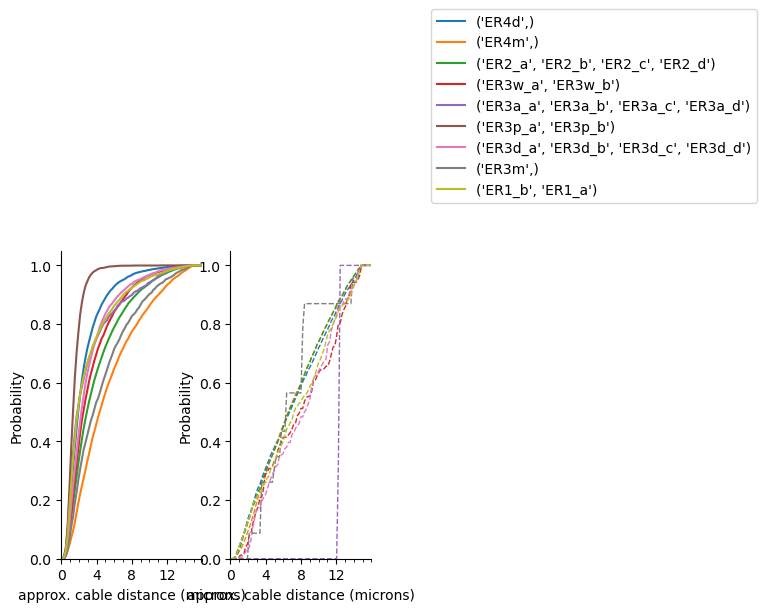

In [28]:
groups = (('ER4d',), ('ER4m',),
          ('ER2_a', 'ER2_b', 'ER2_c', 'ER2_d'),
          ('ER3w_a', 'ER3w_b'), ('ER3a_a', 'ER3a_b', 'ER3a_c', 'ER3a_d'),
          ('ER3p_a', 'ER3p_b'),
          ('ER3d_a', 'ER3d_b', 'ER3d_c', 'ER3d_d'),
          ('ER3m',),
          ('ER1_b', 'ER1_a'))

fig, ax = plt.subplots(1,2, figsize=[4,4])
plot_df = df.loc[df['source']=='el']
bins = np.linspace(0,16,80)
for i, type in enumerate(groups):

    
    sns.histplot(data=plot_df.loc[plot_df['er'].isin(type)],
                 x='distances', bins=bins, ax=ax[0], fill=False,
                 stat='probability', element='poly', common_norm=False,
                 cumulative=True)


# ax.set_ylim([0,.15])

fig.legend(groups, bbox_to_anchor=(1.05, 1), loc='lower left', borderaxespad=0.)

# fig, ax = plt.subplots()
exr2_df = df.loc[df['source']=='exr2']
for i, type in enumerate(groups):

    sns.histplot(data=exr2_df.loc[exr2_df['er'].isin(type)],
             x='distances', bins=bins, ax=ax[1], fill=False,
             stat='probability', element='poly', common_norm=False,
             cumulative=True, linestyle='--', linewidth=1)
    
for a in ax.flatten():
    a.set_xlabel('approx. cable distance (microns)')
    a.set_xticks([0,4,8,12])
    a.xaxis.set_minor_locator(AutoMinorLocator())

    # ax.set_title(type)
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_xlim([0,16])

fig.savefig(figfolder / 'all_dist_to_EPG_syn_cumulative.pdf', bbox_inches='tight')